# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.


In [1]:
# Importing libraries
import os
import io
import boto3
import sagemaker
from sagemaker import PCA

import mxnet as mx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import pickle, gzip, urllib, json
import csv

from utils import *

%matplotlib inline

In [2]:
# sagemaker session, role
session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = 'sagemaker-ap-south-1-714138043953'

In [3]:
s3_client = boto3.client('s3')

obj_list = s3_client.list_objects(Bucket=bucket)
file=[]
for contents in obj_list['Contents']:
    file.append(contents['Key'])

print(file)

['arvato-segmentation/attributes.csv', 'arvato-segmentation/azdias.pkl', 'arvato-segmentation/customers.pkl', 'arvato-segmentation/information.csv', 'arvato-segmentation/pca-2020-10-22-18-22-24-482/output/model.tar.gz', 'sagemaker-record-sets/PCA-2020-10-21-22-08-10-232/.amazon.manifest', 'sagemaker-record-sets/PCA-2020-10-21-22-08-10-232/matrix_0.pbr', 'sagemaker-record-sets/PCA-2020-10-22-18-20-50-084/.amazon.manifest', 'sagemaker-record-sets/PCA-2020-10-22-18-20-50-084/matrix_0.pbr']


In [4]:
def read_pkl_s3(bucket, key):
    """Function to read pickle files from S3
    :param bucket: S3 bucket name
    :param key: path to file
    :return: data
    """
    response = s3_client.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    data = pickle.loads(body)
    
    return data

In [8]:
azdias = read_pkl_s3(bucket, file[1])
customers = read_pkl_s3(bucket, file[2])

print(azdias.shape)
print("_"*100)
print(customers.shape)

(791253, 353)
____________________________________________________________________________________________________
(140866, 356)


In [7]:
sep_attr = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers_az = customers.drop(sep_attr, axis = 1).copy()
customers_az.shape

(140866, 353)


## Pricipal Component Analysis
Before training our machine learning model, we'll reduce the demension of our data for which we'll use **Incremental Principal Component Analysis.** Increamental PCA requires to split data into smaller batches, which are fed to IPCA one at a time.

In [13]:
prefix = 'arvato-segmentation'
output_path = 's3://{}/{}/'.format(bucket, prefix)
N_COMPONENTS = 352

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.m4.xlarge',
             output_path=output_path,
             num_components=N_COMPONENTS)

In [14]:
%%time
pca_SM.fit(pca_SM.record_set(azdias.values.astype('float32')))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-22 21:02:37 Starting - Starting the training job...
2020-10-22 21:02:39 Starting - Launching requested ML instances...
2020-10-22 21:03:37 Starting - Preparing the instances for training.........
2020-10-22 21:04:51 Downloading - Downloading input data...
2020-10-22 21:05:31 Training - Downloading the training image...
2020-10-22 21:06:07 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[10/22/2020 21:05:54 INFO 139851986401088] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/22/2020 21:05:54 INFO 139851986401088] Merging with provided configuration from /opt/ml/input/config/hyperparameters.

In [16]:
pca_training_job_name = 'pca-2020-10-22-21-02-37-025'

# where the model is saved, by default
pca_model_key = os.path.join(prefix, pca_training_job_name, 'output/model.tar.gz')
print(pca_model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket).download_file(pca_model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

arvato-segmentation/pca-2020-10-22-21-02-37-025/output/model.tar.gz


2304

In [17]:
# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

### PCA Model Attributes

Three types of model attributes are contained within the PCA model.

    mean: The mean that was subtracted from a component in order to center it.
    v: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
    s: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

We are only interested in v and s.

From s, we can get an approximation of the data variance that is covered in the first n principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for all components:
$$\begin{equation*} \frac{\sum_{n}^{ } s_n^2}{\sum s^2} \end{equation*}$$

From v, we can learn more about the combinations of original features that make up each principal component.


In [18]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [19]:
def explained_variance(s, n_top_components):
    """Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.
    """
    start_idx = N_COMPONENTS - n_top_components
    top_principal_components = s.iloc[start_idx:, :]
    
    variance = np.sum(np.square(top_principal_components)) / np.sum(np.square(s))
    
    return variance[0]

In [22]:
exp_variance = []

# calculate the explained variance
for n in range(1, 354):
    evar = explained_variance(s, n)
    exp_variance.append(evar)
    if n % 50 == 0:
        print('Explained variance for top {} is: {}'.format(n, evar))


Explained variance for top 50 is: 0.606728732585907
Explained variance for top 100 is: 0.7550870776176453
Explained variance for top 150 is: 0.8589470386505127
Explained variance for top 200 is: 0.9290238618850708
Explained variance for top 250 is: 0.9682955145835876
Explained variance for top 300 is: 0.9900360703468323
Explained variance for top 350 is: 0.9999566078186035


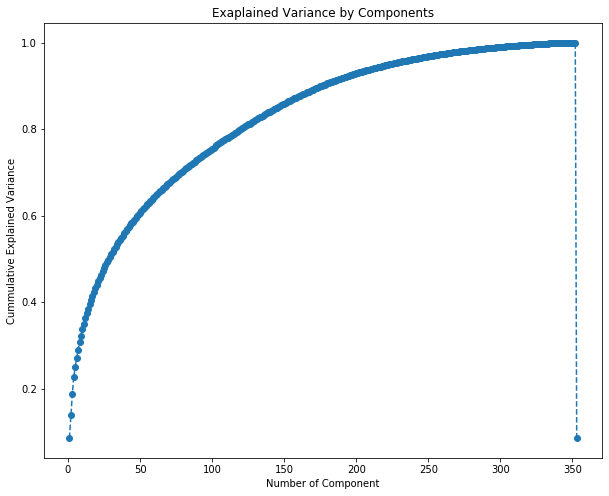

In [25]:
plt.figure(figsize=(10,8))
plt.plot(range(1, len(exp_variance) + 1), exp_variance, marker='o',linestyle='--')
plt.title("Exaplained Variance by Components")
plt.xlabel("Number of Component")
plt.ylabel("Cummulative Explained Variance")
plt.show()

We can notice **top 150 components** are able to explain 85% of the variance in our data. 80% is generally accepted threshold for data variance.

In [26]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS - component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

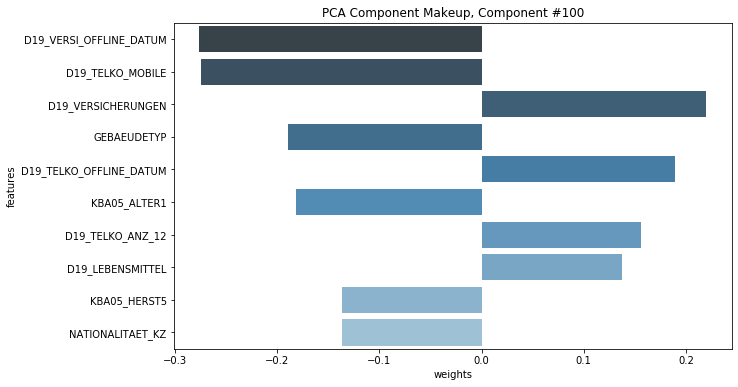

In [27]:
# display makeup of first component
num=100
display_component(v, azdias.columns.values, component_num=num, n_weights=10)

### Deploying PCA Model

In [28]:
%%time
# this takes a little while, around 7mins
# pca_SM = sagemaker.estimator.Estimator.attach(training_job_name) # attaching pre-trained model
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!CPU times: user 249 ms, sys: 4.74 ms, total: 254 ms
Wall time: 6min 31s


In [32]:
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    
    for array in split_array:
        predictions = ','.join(str(prediction) for prediction in [predictions, pca_predictor.predict(array)])
        print('-', end='')
    return np.fromstring(predictions[1:], sep=',')

In [34]:
azdias_pca = predict(azdias.values.astype('float32'), 4000)
# check out the first item in the produced training features
# data_idx = 0
# print(train_pca[data_idx])split_array

----------------------------------------------------------------------------------------------------------------------

MemoryError: 

In [36]:
customers_pca = predict(customers_az.values.astype('float32'), 4000)

------------------------------------

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.


In [40]:
# check out the first item in the produced training features
data_idx = 1
customers_pca

array([], dtype=float64)

In [ ]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, df, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param df: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    df_transformed = pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components = data.label['projection'].float32_tensor.values
        df_transformed = df_transformed.append([list(components)])

    # index by county, just like counties_scaled
    azdias_transformed.index = df.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    df_transformed = df_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return df_transformed.iloc[:, ::-1]

In [25]:
# specify top n
top_n = 200

# calazdiasur function and create a new dataframe
azdias_transformed = create_transformed_df(train_pca, azdias, n_top_components=top_n)
customers_transformed = create_transformed_df(train_pca, customers_az, n_top_components=top_n)

# add descriptive columns
PCA_list=[]
for i in range(1, 151):
    PCA_list.append('c_'+str(i))

azdias_transformed.columns = PCA_list 
customers_transformed.columns = PCA_list

# print result
azdias_transformed.head()

NameError: name 'train_pca' is not defined

In [36]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)